# Data Clustering

## Instructions

- Download and open your copy of the notebook.
- Follow the instructions within the notebook to complete the analysis using the provided data files.
- Ensure that you upload the data files to your Google Drive before running the notebook, and adjust the file paths accordingly.
- Complete code when you see three dots (...)

## Remember:

We are using labeled data just to show the effect of the different algorithms. In reality, when working with unsupervised learning, you won't have the labels. This means that you'll need to rely on the intrinsic properties of your data to find meaningful patterns and structure. Dimensionality reduction helps to visualize and understand these patterns, but keep in mind:

1. **Interpretation Without Labels:** Without labels, you'll have to interpret the results based on the clustering, grouping, or distribution of the data points in the reduced dimensional space.
2. **Evaluation:** Since there are no labels, you might evaluate the effectiveness of the dimensionality reduction technique based on how well it separates distinct clusters or how it preserves the structure of the data.
3. **Exploration:** Use these techniques as exploratory tools to identify trends, outliers, and other important aspects of your data before moving on to more advanced analyses.

By experimenting with different methods, you'll gain a better understanding of which techniques work best for your specific dataset and objectives.

Install packages and import them

## Content

In this exercise, we will:
- Explore data clustering using two different methods.
- We’ll learn how to optimize the clustering algorithms and visualize and evaluate the performance of each one.

## About this dataset
- This dataset consists of data extracted from videos where individuals performed various micro-gestures, such as head movements or subtle arm motions.
- The features in this dataset were derived from raw video files.
As before, will visualized the correlations in the dataset, but this time we focused on plotting pairs of variables with high correlation.
- You'll notice that out of 700+ variables, only a few pairs show high correlation. This is because the data has already undergone a feature extraction process. Originally, the data consisted of video frames, each with over 200k pixels (features).
- The feature extraction was done using an autoencoder, which we’ll explore in the next chapter

## Imports and helper functions


In [1]:
# install umap
try:
  import umap
except:
  !pip install umap-learn
try:
  import ipywidgets
except:
  !pip install ipywidgets matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns
import os
from umap import UMAP
from ipywidgets import interact
from matplotlib.widgets import Slider

print('Successfully imported all packages')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00
Successfully imported all packages


In [32]:
# Helper function for getting and plotting correlation heatmap
def get_correlation_heatmap(df, plot_flag=True, fig_size=(8,8)):
  # Assuming your DataFrame is named df
  # 1. Calculate the correlation matrix
  corr_matrix = df.corr().abs()
  if plot_flag:
    # 2. Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # 3. Set up the matplotlib figure
    plt.figure(figsize=fig_size)

    # 4. Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, linewidths=.5)

    # 5. Add title and labels
    plt.title('Correlation Matrix Heatmap', fontsize=16)
    plt.show()
  return corr_matrix

# Helper function for extracting pairs of variables with high correlation
def get_pairs_with_high_corr(corr_matrix, threshold=0.8):


  # Mask the upper triangle of the matrix and remove the diagonal
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

  # Apply the mask to the correlation matrix and get high correlation pairs
  high_corr = corr_matrix.where(mask).stack()
  high_corr = high_corr[high_corr > threshold]

  # Convert the result to a DataFrame
  high_corr_df = high_corr.reset_index()
  high_corr_df.columns = ['Variable 1', 'Variable 2', 'Correlation']
  high_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)
  return high_corr_df

# Helper function for plotting embedding
def plot_embedding(X_embedded, y, title):
    plt.figure(figsize=(10, 8))

    if y is not None:
        if isinstance(y[0], str):  # Check if labels are text
            unique_labels = np.unique(y)  # Get unique labels
            colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Generate colors

            for i, label in enumerate(unique_labels):
                plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1],
                            color=colors[i], label=label, edgecolor='k')

            plt.legend(title='Labels')
        else:
            scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis')
            plt.colorbar(scatter)
    plt.title(title)

# Choosing the optimal number of clusters

# Function to compute inertia (within-cluster sum of squares)
def compute_inertia(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data)
    return kmeans.inertia_

# Function to find the elbow point
def find_elbow(x, y):
    # Normalize the x and y values
    x_norm = (x - min(x)) / (max(x) - min(x))
    y_norm = (y - min(y)) / (max(y) - min(y))

    # Calculate the distances from each point to the line connecting the first and last points
    x_line = np.array([x_norm[0], x_norm[-1]])
    y_line = np.array([y_norm[0], y_norm[-1]])

    distances = []
    for i in range(len(x)):
        point = np.array([x_norm[i], y_norm[i]])
        dist = np.abs(np.cross(x_line - y_line, point - y_line)) / np.linalg.norm(x_line - y_line)
        distances.append(dist)

    # The elbow is the point with the maximum distance
    elbow_index = np.argmax(distances)
    return x[elbow_index], distances

def plot_umap_comparison(X_umap, gt, clustering_labels):
    # Create a DataFrame for plotting
    df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap['Clustering'] = clustering_labels
    df_umap['Ground Truth'] = gt

    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot UMAP with Clustering Labels
    sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Clustering', ax=axes[0], palette='viridis')
    axes[0].set_title('UMAP with Clustering Labels')
    axes[0].legend(title='Clustering', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot UMAP with Ground Truth Labels
    sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Ground Truth', ax=axes[1], palette='viridis')
    axes[1].set_title('UMAP with Ground Truth Labels')
    axes[1].legend(title='Ground Truth', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Data Preparation and Visualization

## Connet to drive and load dataset

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the path to the CSV file
# Ensure you replace 'path_to_your_folder' and 'filename.csv' with their actual file path
csv_file_path = '/content/drive/My Drive/Quantifying natural behavior - unsupervised learning/data/human_micrgestures.csv'


Mounted at /content/drive


In [25]:
  df_all = pd.read_csv(csv_file_path)
  df=df_all.drop(['labels_coarse','labels_fine'],axis=1)

## Visualize correleaction

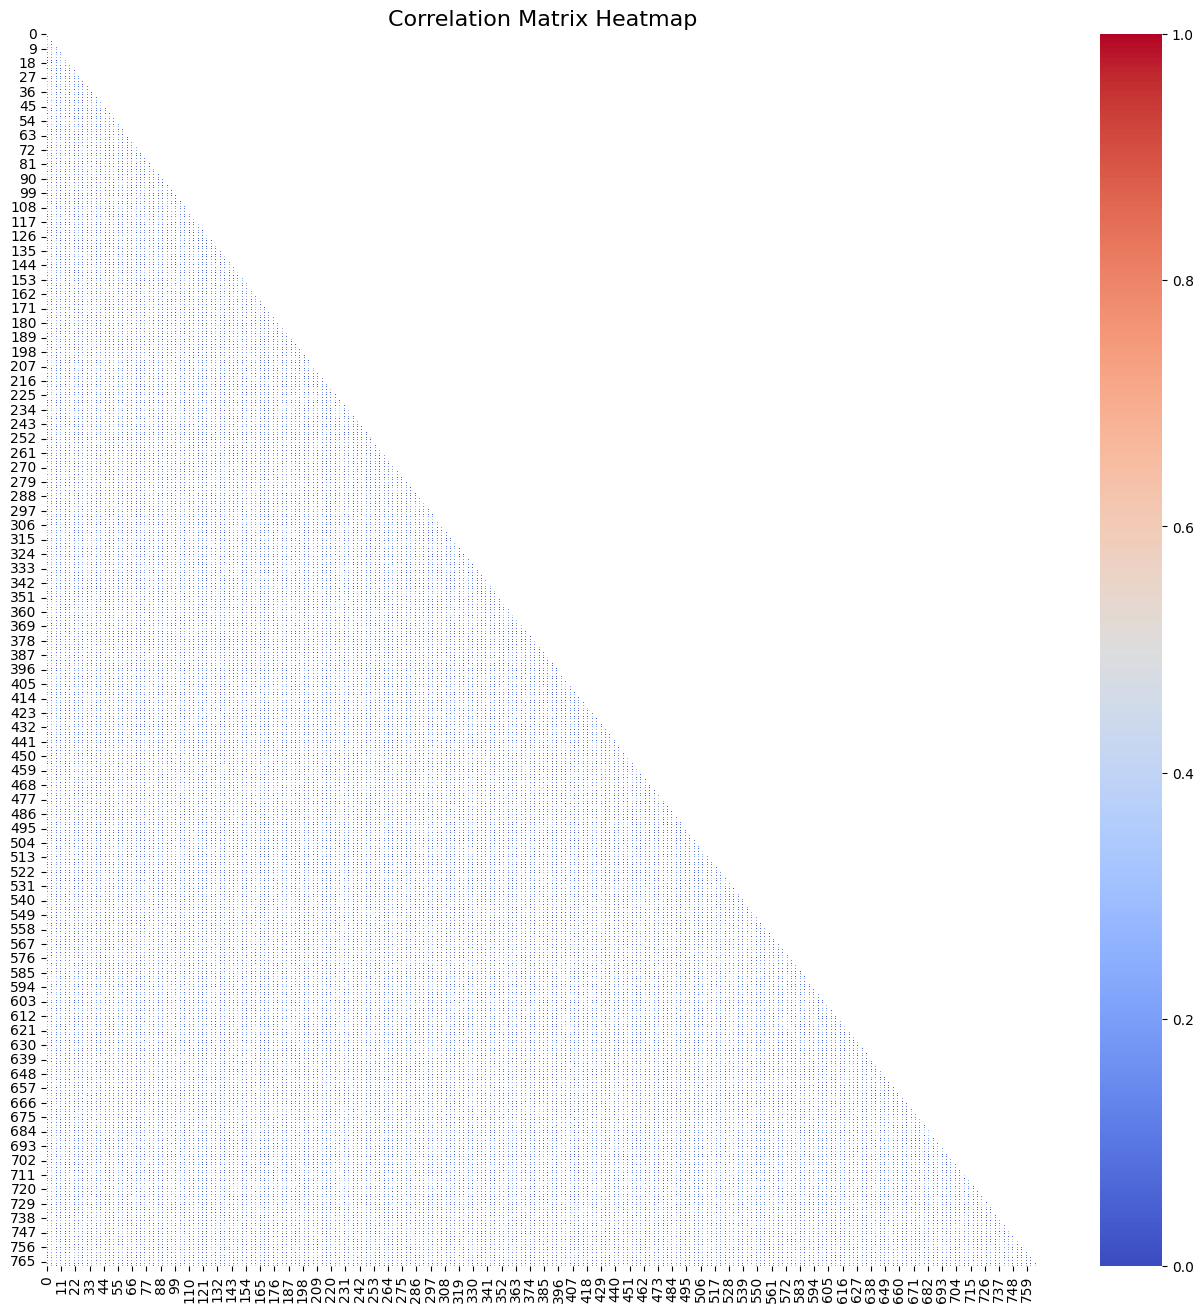

Number of pairs of variables with high correlation (corr>0.65):13


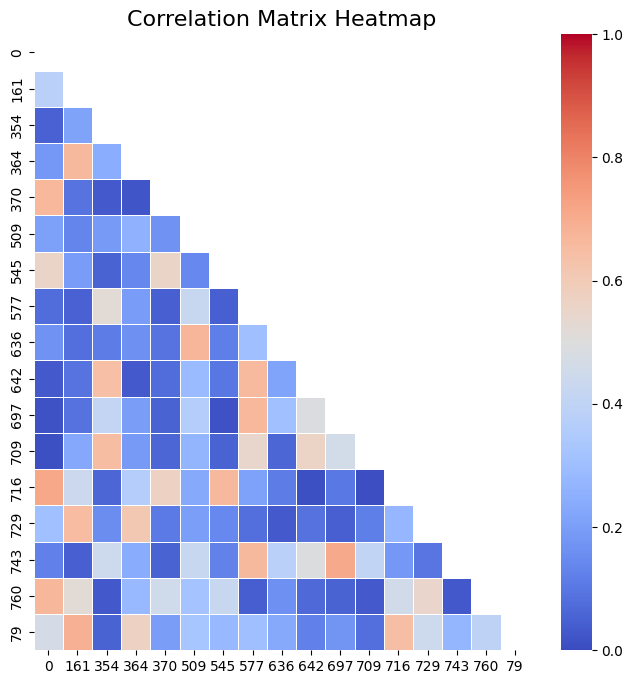

In [44]:
corr_matrix = get_correlation_heatmap(df, True, fig_size=(16,16))
corr_th = 0.65
high_corr_df = get_pairs_with_high_corr(corr_matrix, corr_th)
high_corr_vars = list(set(list(high_corr_df['Variable 1']) + list(high_corr_df['Variable 2'])))
high_corr_vars.sort()
df_high_corr = df[high_corr_vars]
print(f"Number of pairs of variables with high correlation (corr>{corr_th}):{len(high_corr_df)}")

high_corr_matrix = get_correlation_heatmap(df_high_corr, True, fig_size=(8,8))

## Data scaling labels extraction

In [26]:
# Preprocess the data
X = df.values
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Get labels for evaluation
y_txt = df_all['labels_coarse']
y_txt_fine = df_all['labels_fine']

## Extrating umap embeddings for visualiztion

In [7]:
# Set random state to 42 to ensure the results as the same for everyone, do not do this in real data
random_state = 42
np.random.seed(random_state)

umap_reducer = UMAP(n_components=2, random_state=random_state)
X_umap = umap_reducer.fit_transform(X_scaled)
df[['umap1','umap2']] = X_umap

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Visualize the data
**Note:** You will not be able to do this in real data since you will not have labels!

We are using this as an example to evaluate the clusting methods

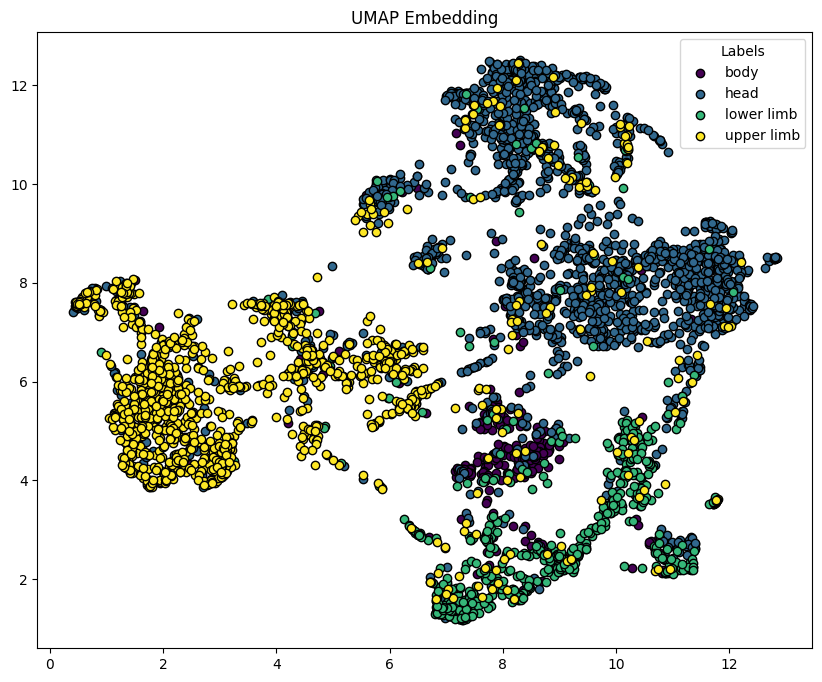

In [28]:
plot_embedding(X_umap, y_txt, "UMAP Embedding")

# 1. K-means Clustering
## How K-means Works

K-means is a popular and straightforward clustering algorithm used to partition data into k clusters. The algorithm works iteratively to assign each data point to one of the k clusters based on the feature similarity.
Key Concepts

1. Centroids: The algorithm identifies k centroids, one for each cluster.
2. Assignment: Each data point is assigned to the nearest centroid, forming k clusters.
3. Update: The centroids are recalculated as the mean of all points assigned to each cluster.
4. Convergence: Steps 2 and 3 are repeated until the centroids no longer change significantly.

## Parameters of K-means

1. **n_clusters:**
- What is n_clusters?
  - The number of clusters to form. It is the primary parameter that needs to be set before running the algorithm.
- The effect of n_clusters:
  - The number of clusters, directly determines the grouping of data points.
  - Too small a n_clusters value might result in large clusters with high within-cluster variance.
  - Too large a n_clusters value might lead to clusters with very few points and potentially overfitting.

- Choosing Optimal n_clusters

  Selecting the optimal number of clusters, k, is crucial for meaningful clustering. Here are some common methods:

  - Elbow Method:
    - Plot the inertia (within-cluster sum of squares) for different values of n_clusters.
    - Look for the "elbow" point where the rate of decrease sharply slows. This point suggests a good balance between cluster number and tightness.


  - Domain Knowledge:
    - Use prior knowledge about the data to estimate a reasonable number of clusters.
    - For example, if you know there are approximately n_clusters distinct groups in your data, you can set n_clusters accordingly.

## Summary

K-means is a widely-used clustering algorithm that partitions data into k clusters based on feature similarity. The number of clusters, k, is a crucial parameter that can be determined using methods like the elbow method, silhouette analysis, or domain knowledge.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


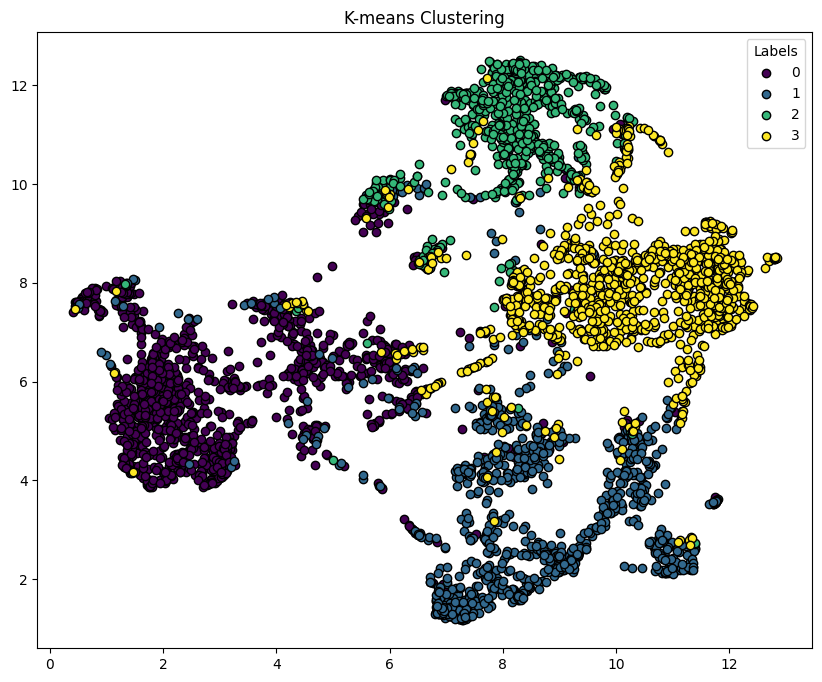

In [63]:
# Perform K-means clustering

kmeans = KMeans(...=..., random_state=random_statem, n_init='auto') # <=== complete code
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled).astype(str) # We are convering the type to string from int

# Visualize K-means results using umap embedding
plot_embedding(X_umap, df['kmeans_cluster'], "K-means Clustering")

In [ ]:
# Show hint

In [64]:
# @title
# kmeans = KMeans(n_clusters=4, random_state=random_state) # <=== complete code

## Choosing the optimal number of clusters

Determining the right number of clusters is a crucial step in cluster analysis. It's especially important in animal behavior studies, where each cluster might represent a distinct behavioral state. We'll use two common methods to help us choose the optimal number of clusters:

- **The Elbow Method**:
   - This method plots the inertia (within-cluster sum of squares) against the number of clusters.
   - As the number of clusters increases, the inertia typically decreases.
   - The "elbow" in the resulting curve suggests the optimal number of clusters.
   - After this point, adding more clusters doesn't significantly reduce inertia.


There are many ways to choose the optimal number, but it's important to balance these results with domain knowledge:

- In animal behavior studies, the biological significance of the clusters is crucial.
- Sometimes, a slightly suboptimal number of clusters from a statistical perspective might make more sense biologically.
- Always interpret the results in the context of what's known about the animal's behavior and ecology.

We'll implement both methods and compare their results to make an informed decision about the number of clusters to use in our analysis.

## Task: Find the Best Number of Clusters

In this task, you'll explore how to find the optimal number of clusters (k) for your data using the Elbow Method. The goal is to minimize the "inertia" (the within-cluster sum of squares) by finding a balance between the number of clusters and the tightness of those clusters.

### What to Do:

1. Use the slider to adjust the number of clusters (k) and observe the resulting plot. The red vertical line represents your chosen k value.
2. Notice how the inertia decreases as you increase the number of clusters. Your goal is to identify the point where adding more clusters doesn't significantly reduce inertia—this is the "elbow" point.
3. While this interactive approach helps you understand the process, in real-life scenarios, you can directly calculate the optimal k by finding the point with the maximum distance from the line connecting the first and last points on the plot. This method is already calculated for you in the background.

Note: You don't have to manually search for the optimal k in real life—the code pre-calculates the distances, and you can find the best k immediately by looking at the distance values.

In [36]:
# @title
# Pre-calculate the distances for the Elbow Method
def find_elbow(x, y):
    # Normalize the x and y values
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

    # Line connecting the first and last points
    x_line = np.array([x_norm[0], x_norm[-1]])
    y_line = np.array([y_norm[0], y_norm[-1]])

    distances = []
    for i in range(len(x)):
        point = np.array([x_norm[i], y_norm[i]])
        dist = np.abs(np.cross(x_line - y_line, point - y_line)) / np.linalg.norm(x_line - y_line)
        distances.append(dist)

    # Find the index of the maximum distance
    elbow_index = np.argmax(distances)
    return distances

# Assume k_range and inertias are precomputed
k_range = np.array(range(1, 11))
print('Calculating inertias')
inertias = np.array([compute_inertia(k, X_scaled) for k in k_range])  # Replace with your precomputed inertia values
print('Calculating distances')
distances = find_elbow(k_range, inertias)

# Define the plotting function with a slider
def plot_elbow(k):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    plt.suptitle('Finding the Optimal Number of Clusters Using Elbow')

    # Primary y-axis: Inertia
    ax1.plot(k_range, inertias, 'bo-', label='Inertia')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')

    # Secondary y-axis: Distances
    ax2 = ax1.twinx()
    ax2.plot(k_range, distances, 'go--', label='Distance', alpha=0.5)
    ax2.set_ylabel('Distance')

    # Add a vertical line and display the current distance
    ax1.axvline(x=k, color='r', linestyle='--', label='Selected k')
    ax2.plot(k, distances[k-1], 'ro')  # Plot the point on the distance curve
    ax2.text(k, distances[k-1], f'{distances[k-1]:.4f}', fontsize=10, ha='left', va='bottom')

    ax1.set_title(f'Elbow Method: k={k}, Inertia={inertias[k-1]:.2f}, Distance={distances[k-1]:.4f}')

    fig.legend(loc='upper right')
    plt.show()

# Create an interactive slider
interact(plot_elbow, k=(1, 10, 1))
plt.show()

Calculating inertias
Calculating distances


interactive(children=(IntSlider(value=5, description='k', max=10, min=1), Output()), _dom_classes=('widget-int…

## Task: Evaluate Clustering Performance

After finding the optimal number of clusters using the Elbow Method, it is important to assess how well the clustering algorithm has performed compared to the ground truth (GT).

We will compare the clusters obtained from K-means to the ground truth labels to see how well our clustering matches the actual classifications. This will help us understand the quality of the clustering and whether it aligns with the expected groups.

Steps:

1. Run K-means with the optimal number of clusters identified.
2. Compare the resulting clusters with the ground truth labels.
3. Use metrics such as the adjusted Rand index (ARI) or the silhouette score to evaluate the clustering quality.

In [9]:
# Assuming the optimal number of clusters found is `best_k`
best_k = ...4  # <=== Replace with the actual optimal k value from your slider

# Run K-means with the optimal number of clusters
kmeans = KMeas(... # <=== Complete code
clusters = kmeans... # <=== Complete code

# Calculate performance metrics
ari = adjusted_rand_score(y_txt, clusters)
silhouette_avg = silhouette_score(X_scaled, clusters)

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Average Silhouette Score: {silhouette_avg:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.379
Average Silhouette Score: 0.072


In [ ]:
# Hint

In [6]:
# kmeans = KMeans(n_clusters=best_k, random_state=42)
# clusters = kmeans.fit_predict(X_scaled)


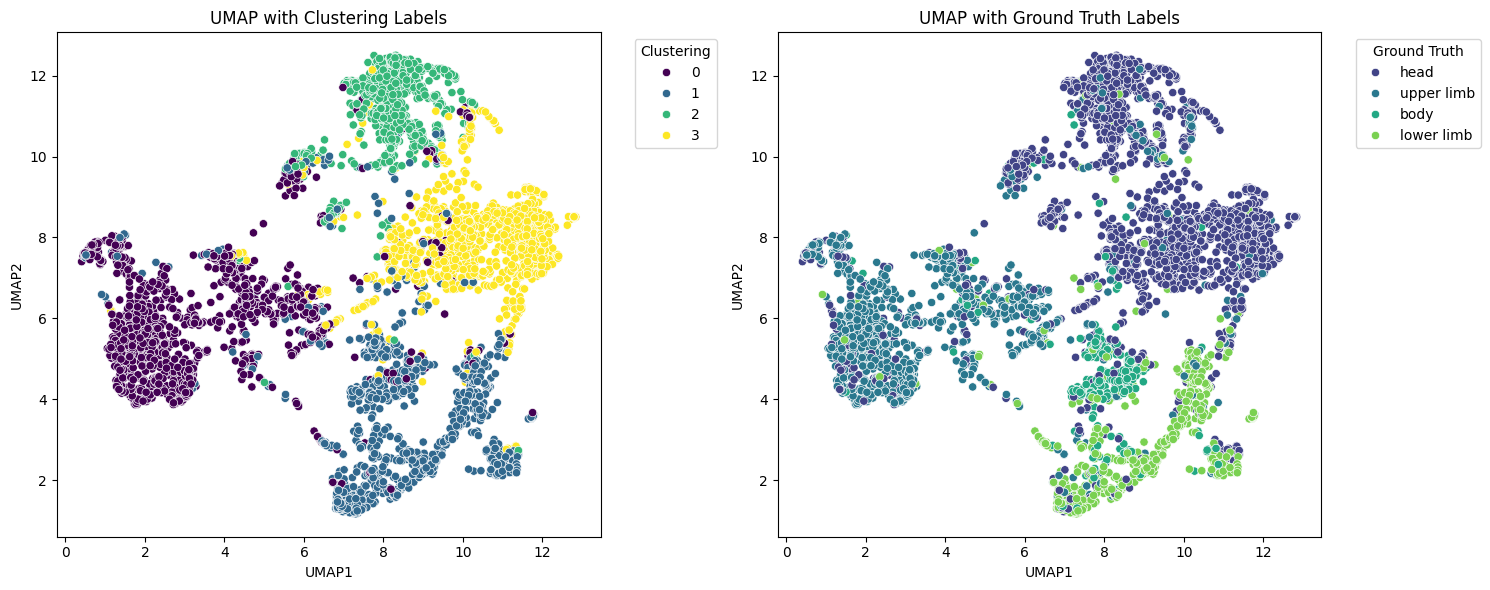

In [10]:
plot_umap_comparison(X_umap, y_txt, clusters)

# Supplemental: Exploring Additional Clustering Methods

Clustering is more than just K-means. There are several other techniques, each suited for different types of data and clustering needs. Here are a few more methods you can explore. The best choice depends on the nature of your data and the problem at hand. Be sure to check out their documentation to understand how they work and when to use them.

1. **Hierarchical Clustering:** Builds a hierarchy of clusters either by iteratively merging smaller clusters (agglomerative) or splitting larger clusters (divisive).
2. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise):** Groups together points that are close to each other based on a distance measurement and a minimum number of points, and identifies noise points.
3. **Spectral Clustering:** Uses the eigenvalues of a similarity matrix to reduce dimensionality before applying clustering algorithms.
4. **Gaussian Mixture Models (GMM):** Models the data as a mixture of several Gaussian distributions, and finds the clusters that best fit this model.


ARI for Hierarchical Clustering: 0.292
Silhouette Score for Hierarchical Clustering: 0.047


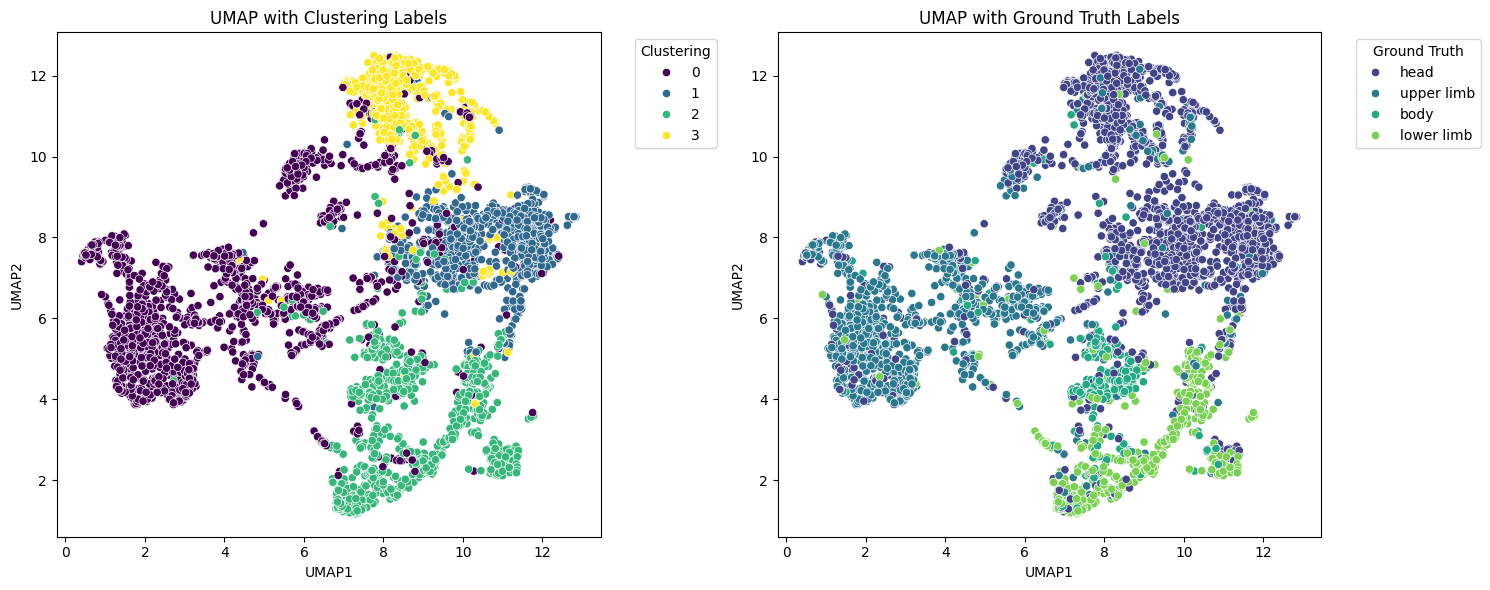

In [30]:
# Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Apply Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
clusters_agg = agg_clustering.fit_predict(X_scaled)

# Compute scores
y = y_txt
ari_agg = adjusted_rand_score(y, clusters_agg)
silhouette_agg = silhouette_score(X_scaled, clusters_agg)


print(f"ARI for Hierarchical Clustering: {ari_agg:.3f}")
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_agg:.3f}")

plot_umap_comparison(X_umap, y, clusters_agg)

ARI for DBSCAN: 0.000
Silhouette Score for DBSCAN: -1.000


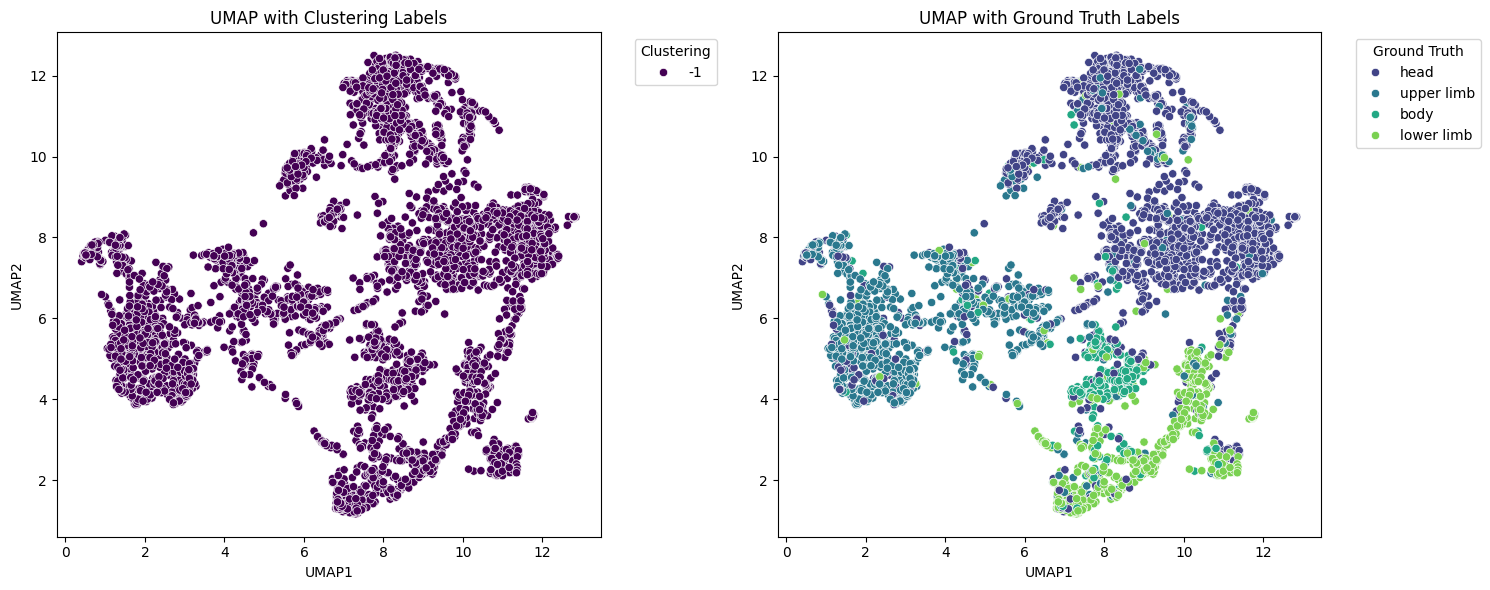

In [19]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Compute scores
ari_dbscan = adjusted_rand_score(y_txt, clusters_dbscan)
try:
  silhouette_dbscan = silhouette_score(X_scaled, clusters_dbscan)
except:
  silhouette_dbscan = -1


print(f"ARI for DBSCAN: {ari_dbscan:.3f}")
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.3f}")

plot_umap_comparison(X_umap, y_txt, clusters_dbscan)

ARI for Spectral Clustering: 0.366
Silhouette Score for Spectral Clustering: 0.071


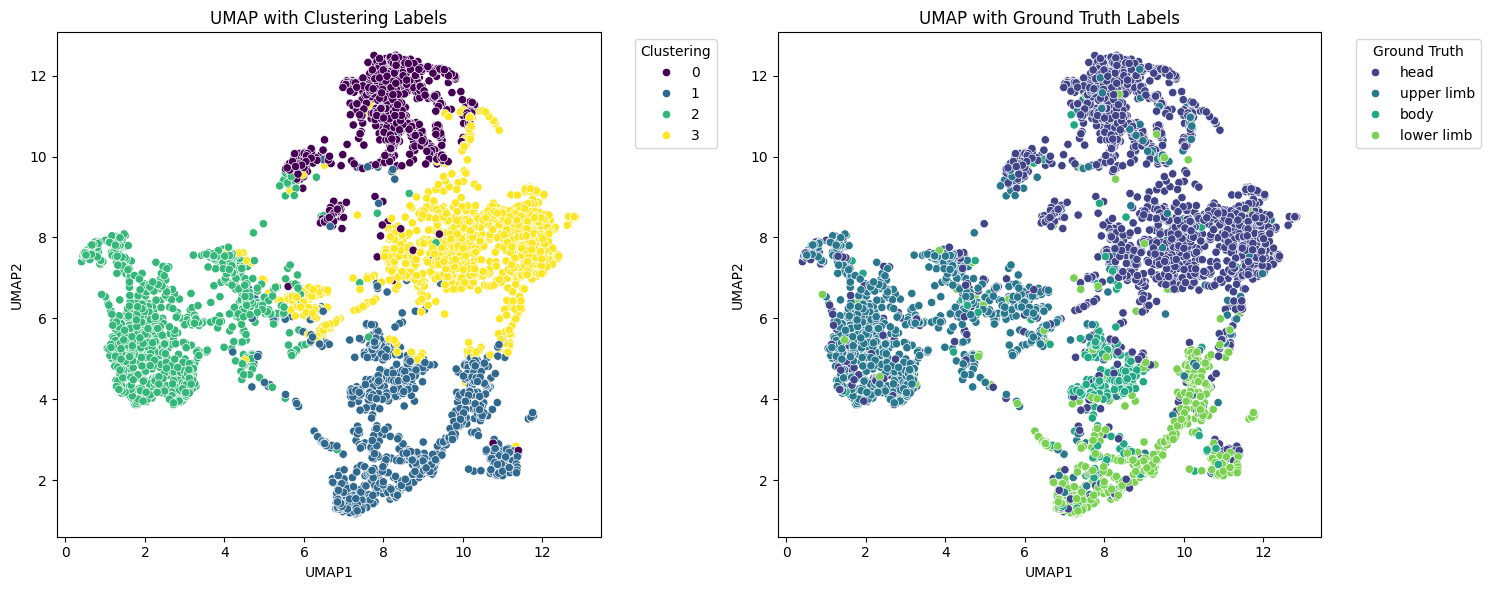

In [21]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors')
clusters_spectral = spectral.fit_predict(X_scaled)

# Compute scores
ari_spectral = adjusted_rand_score(y_txt, clusters_spectral)
silhouette_spectral = silhouette_score(X_scaled, clusters_spectral)

print(f"ARI for Spectral Clustering: {ari_spectral:.3f}")
print(f"Silhouette Score for Spectral Clustering: {silhouette_spectral:.3f}")

plot_umap_comparison(X_umap, y_txt, clusters_spectral)

ARI for GMM: 0.537
Silhouette Score for GMM: 0.091


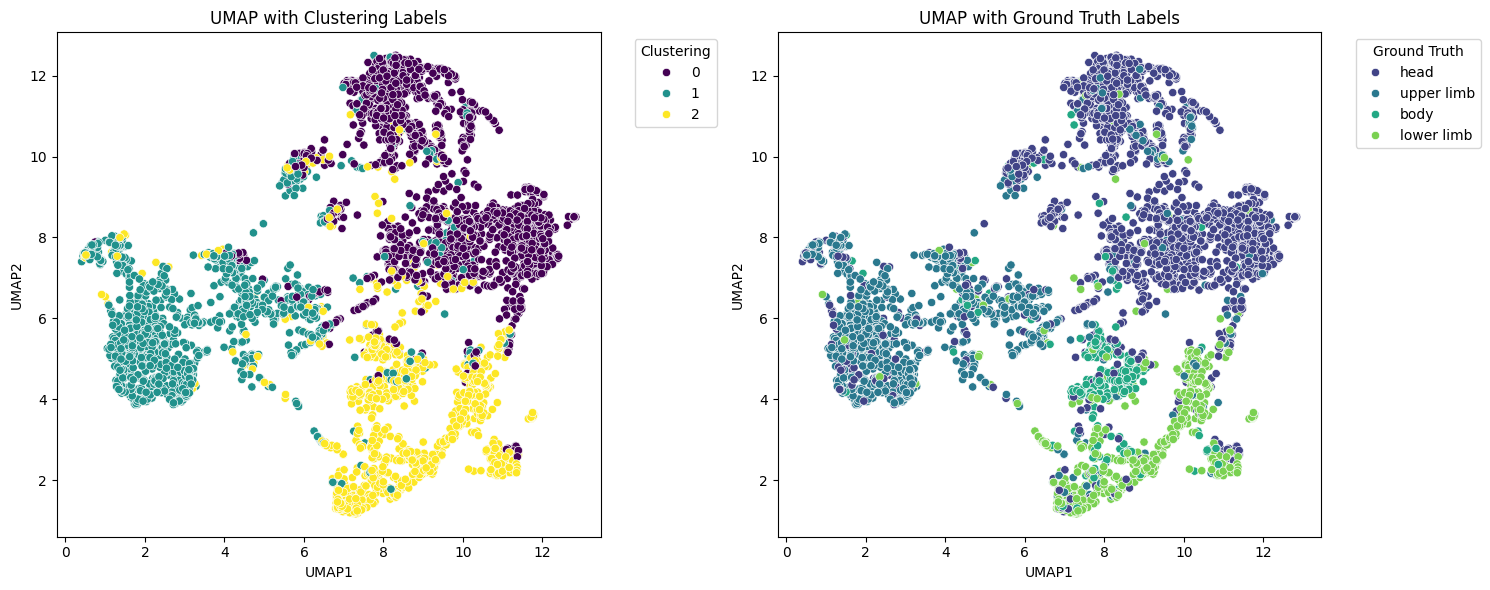

In [22]:
from sklearn.mixture import GaussianMixture

# Apply GMM
gmm = GaussianMixture(n_components=3)
clusters_gmm = gmm.fit_predict(X_scaled)

# Compute scores
ari_gmm = adjusted_rand_score(y_txt, clusters_gmm)
silhouette_gmm = silhouette_score(X_scaled, clusters_gmm)

print(f"ARI for GMM: {ari_gmm:.3f}")
print(f"Silhouette Score for GMM: {silhouette_gmm:.3f}")

plot_umap_comparison(X_umap, y_txt, clusters_gmm)